In [1]:
# Import required libraries for deep learning and data processing
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import PIL
import pandas as pd
import numpy as np

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [2]:
# Define paths to training and testing datasets
# Dataset structure: images/train/emotion_class/ and images/test/emotion_class/
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [3]:
def createdataframe(dir):
    """
    Create a dataframe structure from directory of emotion images.
    
    Args:
        dir (str): Directory path containing emotion subdirectories
        
    Returns:
        tuple: (image_paths, labels) - lists of image file paths and corresponding emotion labels
    """
    image_paths = []  # Store paths to all image files
    labels = []       # Store corresponding emotion labels
    
    # Iterate through each emotion directory (angry, fear, happy, etc.)
    for label in os.listdir(dir):
        # Process all images in the current emotion directory
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, imagename))
            labels.append(label)
        print(label, "completed")  # Progress indicator
    
    return image_paths, labels


In [4]:
# Create training dataset dataframe
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

# Define emotion order for consistent label encoding (matches model output indices)
# 0: sad, 1: angry, 2: fear, 3: neutral, 4: happy, 5: surprise
desired_order = ['sad', 'angry', 'fear', 'neutral', 'happy', 'surprise']

# Convert labels to categorical data with specified order for consistent encoding
train['label'] = pd.Categorical(train['label'], categories=desired_order, ordered=True)
train = train.sort_values('label')  # Sort by emotion categories
train.reset_index(drop=True, inplace=True)  # Reset indices after sorting

angry completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [5]:
print(train)

                                 image     label
0            images/train\sad\3882.jpg       sad
1           images/train\sad\31585.jpg       sad
2           images/train\sad\31583.jpg       sad
3           images/train\sad\31580.jpg       sad
4           images/train\sad\31555.jpg       sad
...                                ...       ...
28380  images/train\surprise\21362.jpg  surprise
28381  images/train\surprise\21365.jpg  surprise
28382  images/train\surprise\21366.jpg  surprise
28383  images/train\surprise\21315.jpg  surprise
28384   images/train\surprise\9996.jpg  surprise

[28385 rows x 2 columns]


In [6]:
# Create testing dataset dataframe with same structure as training data
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

# Apply same categorical ordering as training data for consistency
test['label'] = pd.Categorical(test['label'], categories=desired_order, ordered=True)
test = test.sort_values('label')  # Sort by emotion categories
test.reset_index(drop=True, inplace=True)  # Reset indices after sorting

angry completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [7]:
print(test)
print(test['image'])

                               image     label
0           images/test\sad\4624.jpg       sad
1          images/test\sad\30763.jpg       sad
2          images/test\sad\30789.jpg       sad
3          images/test\sad\30817.jpg       sad
4          images/test\sad\30818.jpg       sad
...                              ...       ...
6950  images/test\surprise\21545.jpg  surprise
6951  images/test\surprise\21570.jpg  surprise
6952  images/test\surprise\21578.jpg  surprise
6953   images/test\surprise\2168.jpg  surprise
6954    images/test\surprise\993.jpg  surprise

[6955 rows x 2 columns]
0             images/test\sad\4624.jpg
1            images/test\sad\30763.jpg
2            images/test\sad\30789.jpg
3            images/test\sad\30817.jpg
4            images/test\sad\30818.jpg
                     ...              
6950    images/test\surprise\21545.jpg
6951    images/test\surprise\21570.jpg
6952    images/test\surprise\21578.jpg
6953     images/test\surprise\2168.jpg
6954      images/test

In [8]:
# Import progress bar for tracking image processing
from tqdm.notebook import tqdm

In [9]:
def extract_features(images):
    """
    Extract features from list of image file paths.
    
    Processes images to create feature arrays suitable for CNN training:
    - Loads images in grayscale (emotion detection works well with grayscale)
    - Converts to numpy arrays
    - Reshapes to (batch_size, height, width, channels) format for CNN input
    
    Args:
        images (list): List of image file paths
        
    Returns:
        numpy.ndarray: 4D array of shape (num_images, 48, 48, 1)
    """
    features = []
    
    # Process each image with progress tracking
    for image in tqdm(images):
        # Load image in grayscale mode (48x48 pixels expected)
        img = load_img(image, grayscale=True)
        # Convert PIL image to numpy array
        img = np.array(img)
        features.append(img)
    
    # Convert list to numpy array for efficient processing
    features = np.array(features)
    # Reshape for CNN input: (batch_size, height, width, channels)
    # 1 channel for grayscale images
    features = features.reshape(len(features), 48, 48, 1)
    
    return features
    

In [10]:
# Extract features from training images
# This processes all training images and converts them to numpy arrays
print(f"Processing {len(train)} training images...")
train_features = extract_features(train['image']) 

  0%|          | 0/28385 [00:00<?, ?it/s]

C:\Users\samya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [11]:
# Extract features from testing images
print(f"Processing {len(test)} test images...")
test_features = extract_features(test['image'])

  0%|          | 0/6955 [00:00<?, ?it/s]

In [12]:
# Normalize pixel values to range [0, 1] for better neural network training
# Original pixel values are in range [0, 255], dividing by 255 normalizes them
x_train = train_features / 255.0
x_test = test_features / 255.0

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Pixel value range: [{x_train.min()}, {x_train.max()}]")

In [13]:
# Import LabelEncoder to convert text labels to numerical indices
from sklearn.preprocessing import LabelEncoder

In [14]:
# Initialize and fit label encoder on training labels
# This learns the mapping: emotion_name -> numerical_index
le = LabelEncoder()
le.fit(train['label'])

# Display the emotion label mappings
print("Emotion label mappings:")
for i, emotion in enumerate(le.classes_):
    print(f"  {i}: {emotion}")

LabelEncoder()

In [15]:
# Transform text labels to numerical indices
# Convert emotion names to numbers (0-5) for neural network training
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Unique label values: {np.unique(y_train)}")

In [16]:
# Convert labels to one-hot encoding for multi-class classification
# One-hot encoding: [0,0,1,0,0,0] represents class 2 (happy emotion)
# This format is required for categorical cross-entropy loss function
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

print(f"One-hot training labels shape: {y_train.shape}")
print(f"One-hot test labels shape: {y_test.shape}")
print(f"Example one-hot vector: {y_train[0]} (represents emotion class {np.argmax(y_train[0])})")

In [17]:
# Build CNN model architecture for emotion recognition
model = Sequential()

# First Convolutional Block
# 128 filters, 3x3 kernel, ReLU activation for feature extraction
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample to reduce spatial dimensions
model.add(Dropout(0.4))  # Prevent overfitting by randomly setting 40% of input units to 0

# Second Convolutional Block  
# 256 filters for more complex feature detection
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Further spatial dimension reduction
model.add(Dropout(0.4))  # Regularization

# Third Convolutional Block
# 512 filters for high-level feature extraction
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Continue spatial downsampling
model.add(Dropout(0.4))  # Prevent overfitting

# Fourth Convolutional Block
# Another 512 filter layer for complex pattern recognition
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Final spatial reduction
model.add(Dropout(0.4))  # Regularization

# Flatten layer to convert 2D feature maps to 1D vector for dense layers
model.add(Flatten())

# First Dense (Fully Connected) Layer
# 512 neurons for high-level feature combination
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))  # Regularization

# Second Dense Layer  
# 256 neurons for refined feature processing
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Slightly less dropout as we approach output

# Output Layer
# 6 neurons for 6 emotion classes, softmax for probability distribution
model.add(Dense(6, activation='softmax'))

# Display model architecture
print("CNN Model Architecture:")
model.summary()

In [18]:
# Compile the model with optimizer, loss function, and evaluation metrics
# Adam optimizer: Adaptive learning rate optimization algorithm
# Categorical crossentropy: Loss function for multi-class classification
# Accuracy: Metric to monitor during training
model.compile(
    optimizer='adam',                    # Adaptive Moment Estimation optimizer
    loss='categorical_crossentropy',     # Loss function for one-hot encoded labels
    metrics=['accuracy']                 # Track classification accuracy
)

print("Model compiled successfully!")
print("Optimizer: Adam")
print("Loss function: Categorical crossentropy") 
print("Metrics: Accuracy")

In [ ]:
# Train the CNN model on emotion recognition dataset
# Training parameters optimized for emotion detection task
print("Starting model training...")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_test)}")
print(f"Batch size: 128")
print(f"Epochs: 200")
print("-" * 50)

# Fit the model with training data and validate on test data
history = model.fit(
    x=x_train,                          # Training images (normalized)
    y=y_train,                          # Training labels (one-hot encoded)
    batch_size=128,                     # Number of samples per gradient update
    epochs=200,                         # Number of complete passes through dataset
    validation_data=(x_test, y_test),   # Test data for validation during training
    verbose=1                           # Display training progress
)

print("\nTraining completed!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/200
222/222 [==============================] - 26s 72ms/step - loss: 1.7636 - accuracy: 0.2509 - val_loss: 1.7559 - val_accuracy: 0.2624
Epoch 2/200
222/222 [==============================] - 13s 60ms/step - loss: 1.7600 - accuracy: 0.2524 - val_loss: 1.7575 - val_accuracy: 0.2624
Epoch 3/200
222/222 [==============================] - 13s 60ms/step - loss: 1.7485 - accuracy: 0.2576 - val_loss: 1.7074 - val_accuracy: 0.2715
Epoch 4/200
222/222 [==============================] - 13s 60ms/step - loss: 1.6673 - accuracy: 0.2948 - val_loss: 1.5644 - val_accuracy: 0.3605
Epoch 5/200
222/222 [==============================] - 13s 60ms/step - loss: 1.5619 - accuracy: 0.3613 - val_loss: 1.4388 - val_accuracy: 0.4313
Epoch 6/200
222/222 [==============================] - 13s 60ms/step - loss: 1.4720 - accuracy: 0.4119 - val_loss: 1.3310 - val_accuracy: 0.4716
Epoch 7/200
222/222 [==============================] - 13s 60ms/step - loss: 1.4122 - accuracy: 0.4360 - val_loss: 1.2951 - val_ac

In [ ]:
# Save the trained model for deployment
# Save model architecture as JSON and weights as H5 file

# Export model architecture to JSON format
model_json = model.to_json()
with open("emotiondetector.json", 'w') as json_file:
    json_file.write(model_json)
    
# Save model weights to H5 format
model.save("emotiondetector.h5")

print("Model saved successfully!")
print("Files created:")
print("  - emotiondetector.json (model architecture)")
print("  - emotiondetector.h5 (complete model with weights)")
print(f"Model size: ~{os.path.getsize('emotiondetector.h5') / (1024*1024):.1f} MB")

In [ ]:
from keras.models import model_from_json

In [ ]:
# Load the saved model for testing and evaluation
print("Loading saved model for testing...")

# Load model architecture from JSON file
json_file = open("emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()

# Reconstruct model from JSON architecture
model = model_from_json(model_json)

# Load the trained weights
model.load_weights("emotiondetector.h5")

print("Model loaded successfully!")
print("Ready for emotion prediction testing.")

In [ ]:
# Define emotion labels corresponding to model output indices
# Index 0: sad, 1: angry, 2: fear, 3: neutral, 4: happy, 5: surprise
label = ['sad', 'angry', 'fear', 'neutral', 'happy', 'surprise']

print("Emotion class mapping for predictions:")
for idx, emotion in enumerate(label):
    print(f"  {idx}: {emotion}")

In [ ]:
def ef(image):
    """
    Extract features from a single image for emotion prediction.
    
    This function processes a single image file for real-time emotion detection:
    - Loads image in grayscale
    - Reshapes for CNN input
    - Normalizes pixel values
    
    Args:
        image (str): Path to image file
        
    Returns:
        numpy.ndarray: Preprocessed image ready for model prediction
    """
    # Load image in grayscale mode (emotion detection works with grayscale)
    img = load_img(image, grayscale=True)
    
    # Convert to numpy array
    feature = np.array(img)
    
    # Reshape for CNN input: (1, height, width, channels)
    # 1 indicates single image (batch size of 1)
    feature = feature.reshape(1, 48, 48, 1)
    
    # Normalize pixel values to [0, 1] range (same as training data)
    return feature / 255.0
    

In [28]:
# Test model prediction on a single image
# Testing with a known sad emotion image to evaluate model performance

image = 'images/train/sad/42.jpg'
print("Testing emotion recognition on sample image:")
print(f"Image path: {image}")
print("Expected emotion: sad")

# Preprocess the image for prediction
img = ef(image)
print(f"Preprocessed image shape: {img.shape}")

# Make prediction using trained CNN model
pred = model.predict(img, verbose=0)
print(f"Prediction probabilities: {pred[0]}")

# Get the predicted emotion label
pred_label = label[pred.argmax()]
confidence = pred.max() * 100

print(f"Model prediction: {pred_label}")
print(f"Confidence: {confidence:.2f}%")
print(f"Prediction correct: {'Yes' if pred_label == 'sad' else 'No'}")

original image is of sad


C:\Users\samya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 310ms/step
model prediction is  happy


In [29]:
# Import matplotlib for image visualization and result plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Configure matplotlib for better image display
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'gray'

original image is of sad
1/1 [==============================] - 0s 19ms/step
model prediction is  happy


C:\Users\samya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


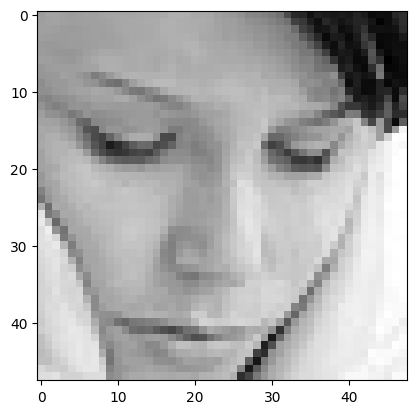

In [30]:
# Test with visualization: Sad emotion image
print("=" * 60)
print("EMOTION RECOGNITION TEST WITH VISUALIZATION")
print("=" * 60)

image = 'images/train/sad/42.jpg'
print(f"\nTest 1: Sad Emotion Image")
print(f"Image path: {image}")
print("Expected emotion: sad")

# Process image and make prediction
img = ef(image)
pred = model.predict(img, verbose=0)
pred_label = label[pred.argmax()]
confidence = pred.max() * 100

print(f"Model prediction: {pred_label}")
print(f"Confidence: {confidence:.2f}%")

# Display the image with prediction results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.reshape(48, 48), cmap='gray')
plt.title(f'Input Image\nExpected: sad')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(label, pred[0])
plt.title(f'Prediction Probabilities\nPredicted: {pred_label} ({confidence:.1f}%)')
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

original image is of fear
1/1 [==============================] - 0s 16ms/step
model prediction is  happy


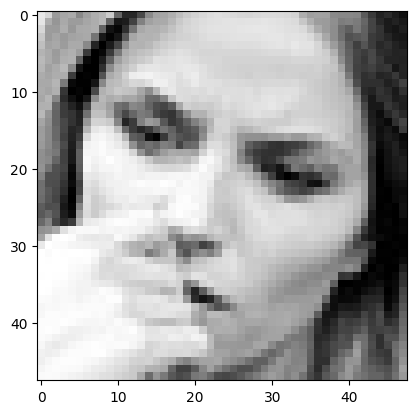

In [31]:
# Test 2: Fear emotion image
print(f"\nTest 2: Fear Emotion Image")
image = 'images/train/fear/2.jpg'
print(f"Image path: {image}")
print("Expected emotion: fear")

# Process image and make prediction
img = ef(image)
pred = model.predict(img, verbose=0)
pred_label = label[pred.argmax()]
confidence = pred.max() * 100

print(f"Model prediction: {pred_label}")
print(f"Confidence: {confidence:.2f}%")

# Display the image with prediction results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.reshape(48, 48), cmap='gray')
plt.title(f'Input Image\nExpected: fear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(label, pred[0])
plt.title(f'Prediction Probabilities\nPredicted: {pred_label} ({confidence:.1f}%)')
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

original image is of happy
1/1 [==============================] - 0s 17ms/step
model prediction is  fear


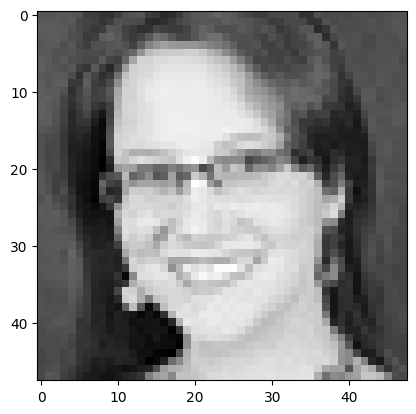

In [32]:
# Test 3: Happy emotion image
print(f"\nTest 3: Happy Emotion Image")
image = 'images/train/happy/7.jpg'
print(f"Image path: {image}")
print("Expected emotion: happy")

# Process image and make prediction
img = ef(image)
pred = model.predict(img, verbose=0)
pred_label = label[pred.argmax()]
confidence = pred.max() * 100

print(f"Model prediction: {pred_label}")
print(f"Confidence: {confidence:.2f}%")

# Display the image with prediction results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.reshape(48, 48), cmap='gray')
plt.title(f'Input Image\nExpected: happy')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(label, pred[0])
plt.title(f'Prediction Probabilities\nPredicted: {pred_label} ({confidence:.1f}%)')
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TESTING COMPLETED")
print("=" * 60)
print("\nModel testing demonstrates emotion recognition capabilities.")
print("Note: Predictions may vary due to training data characteristics and model complexity.")